# Solve higher-order binary optimization problems with Q-CTRL's Optimization Solver


*Usage estimate: 24 minutes on ibm\_fez. (NOTE: This is an estimate only. Your runtime may vary.)*


## Background

This tutorial demonstrates how to solve a higher-order binary optimization (HOBO) problem using the [Optimization Solver, a Qiskit Function by Q-CTRL Fire Opal](https://quantum.ibm.com/functions?id=a8a2b0b6-486a-41b5-8ea4-ada3b108d6b6). The example demonstrated in this tutorial is an optimization problem designed to find the ground-state energy of a random-bond 156-qubit Ising model possessing cubic terms. The Optimization Solver can be used for general optimization problems that can be defined as an objective function.

The Optimization fully automates the hardware-aware implementation steps of solving optimization problems on quantum hardware, and by leveraging [Performance Management](https://quantum.ibm.com/functions?id=c750648c-ba44-4137-8c34-4140a3aaa7a9) for the quantum execution, it achieves accurate solutions at utility scale. For a detailed summary of the full Optimization Solver workflow and benchmarking results, refer to [the published manuscript](https://arxiv.org/abs/2406.01743).

This tutorial walks through the following steps:

1. Define the problem as an objective function
2. Run the hybrid algorithm using the Fire Opal Optimization Solver
3. Evaluate results


## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit Functions (`pip install qiskit-ibm-catalog`)
* SymPy (`pip install sympy`)

You will also need to get access to the Optimization Solver function. [Fill out the form](https://quantum.ibm.com/functions?id=a8a2b0b6-486a-41b5-8ea4-ada3b108d6b6) to request access.


## Setup

First, import the required packages and tools.


In [1]:
# Qiskit Functions Catalog
from qiskit_ibm_catalog import QiskitFunctionsCatalog

# SymPy tools for constructing objective function
from sympy import Poly
from sympy import symbols, srepr

# Tools for plotting and evaluating results
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify

Define your [IBM Quantum™ Platform](http://quantum.ibm.com/) credentials, which will be used throughout the tutorial to authenticate to Qiskit Runtime and Qiskit Functions.


In [ ]:
# Credentials
token = "<YOUR_IQP_API_TOKEN>"
hub = "<YOUR_IQP_HUB>"
group = "<YOUR_IQP_GROUP>"
project = "<YOUR_IQP_PROJECT>"

## Step 1: Define the problem as an objective function


The Optimization Solver accepts either an objective function or a graph as input. In this tutorial, the Ising spin glass minimization problem is defined as an objective function, and it has been tailored for the heavy-hex topology of IBM devices.

Because this objective function contains cubic, quadratic, and linear terms, it falls into the HOBO class of problems, known to be considerably more complicated to solve than conventional quadratic unconstrained binary optimization (QUBO) problems.

For detailed discussion of the construction of the problem definition and previous results obtained from the Optimization Solver refer to [this technical manuscript](https://arxiv.org/abs/2406.01743). The problem was originally defined and evaluated as part of a [paper published by Los Alamos National Laboratory](https://arxiv.org/abs/2312.00997), and it has been adapted to leverage the full device width of the 156-qubit IBM Quantum Heron processors.


In [42]:
qubit_count = 156

# Create symbolic variables to represent qubits
x = symbols([f"x[{i}]" for i in range(qubit_count)])

# # Define a polynomial representing a spin glass model
spin_glass_poly = Poly(-4*x[0]*x[1] - 8*x[1]*x[2]*x[3] + 8*x[1]*x[2] + 4*x[1]*x[3] - 4*x[2] + 8*x[3]*x[4]*x[5] - 4*x[3]*x[5] - 8*x[3]*x[16]*x[23] + 4*x[3]*x[23] - 2*x[3] - 4*x[4] - 8*x[5]*x[6]*x[7] + 8*x[5]*x[6] + 4*x[5]*x[7] - 2*x[5] + 8*x[6]*x[7] - 4*x[6] - 8*x[7]*x[8]*x[9] + 4*x[7]*x[9] - 8*x[7]*x[17]*x[27] + 4*x[7]*x[27] - 6*x[7] + 8*x[8]*x[9] + 8*x[9]*x[10]*x[11] - 4*x[9]*x[11] - 2*x[9] - 8*x[10]*x[11] + 4*x[10] - 8*x[11]*x[12]*x[13] + 4*x[11]*x[13] - 8*x[11]*x[18]*x[31] + 8*x[11]*x[18] + 4*x[11]*x[31] - 2*x[11] + 8*x[12]*x[13] + 8*x[13]*x[14]*x[15] - 4*x[13]*x[15] - 2*x[13] - 8*x[14]*x[15] + 4*x[14] - 8*x[15]*x[19]*x[35] + 8*x[15]*x[19] + 4*x[15]*x[35] - 2*x[15] + 8*x[16]*x[23] + 8*x[17]*x[27] - 4*x[17] + 8*x[18]*x[31] - 8*x[18] + 8*x[19]*x[35] - 8*x[19] + 4*x[20]*x[21] - 4*x[20] - 8*x[21]*x[22]*x[23] + 8*x[21]*x[22] + 4*x[21]*x[23] - 8*x[21]*x[36]*x[41] + 4*x[21]*x[41] - 4*x[21] + 8*x[22]*x[23] - 8*x[22] + 8*x[23]*x[24]*x[25] - 4*x[23]*x[25] - 10*x[23] - 8*x[24]*x[25] + 8*x[25]*x[26]*x[27] - 8*x[25]*x[26] - 4*x[25]*x[27] + 8*x[25]*x[37]*x[45] - 8*x[25]*x[37] - 4*x[25]*x[45] + 14*x[25] - 8*x[26]*x[27] + 4*x[26] + 8*x[27]*x[28]*x[29] - 4*x[27]*x[29] - 2*x[27] - 8*x[28]*x[29] - 8*x[29]*x[30]*x[31] + 4*x[29]*x[31] + 8*x[29]*x[38]*x[49] - 8*x[29]*x[38] - 4*x[29]*x[49] + 6*x[29] + 8*x[30]*x[31] - 4*x[30] - 8*x[31]*x[32]*x[33] + 4*x[31]*x[33] - 6*x[31] + 8*x[33]*x[34]*x[35] - 4*x[33]*x[35] - 8*x[33]*x[39]*x[53] + 8*x[33]*x[39] + 4*x[33]*x[53] - 6*x[33] - 8*x[34]*x[35] + 2*x[35] + 8*x[36]*x[41] - 8*x[37]*x[45] + 4*x[37] - 8*x[38]*x[49] + 4*x[38] + 4*x[40]*x[41] - 8*x[41]*x[42]*x[43] + 4*x[41]*x[43] - 8*x[41] + 8*x[42]*x[43] - 4*x[42] - 8*x[43]*x[44]*x[45] + 8*x[43]*x[44] + 4*x[43]*x[45] - 8*x[43]*x[56]*x[63] + 4*x[43]*x[63] - 6*x[43] - 4*x[44] - 8*x[45]*x[46]*x[47] + 4*x[45]*x[47] + 2*x[45] + 4*x[46] - 8*x[47]*x[48]*x[49] + 8*x[47]*x[48] + 4*x[47]*x[49] - 8*x[47]*x[57]*x[67] + 4*x[47]*x[67] - 2*x[47] - 4*x[48] - 8*x[49]*x[50]*x[51] + 8*x[49]*x[50] + 4*x[49]*x[51] - 2*x[49] + 8*x[50]*x[51] - 8*x[50] - 8*x[51]*x[52]*x[53] + 8*x[51]*x[52] + 4*x[51]*x[53] - 8*x[51]*x[58]*x[71] + 4*x[51]*x[71] - 6*x[51] + 8*x[52]*x[53] - 8*x[52] + 8*x[53]*x[54]*x[55] - 8*x[53]*x[54] - 4*x[53]*x[55] - 2*x[53] + 4*x[54] - 8*x[55]*x[59]*x[75] + 4*x[55]*x[75] - 2*x[55] + 8*x[56]*x[63] + 8*x[57]*x[67] - 4*x[57] + 8*x[58]*x[71] + 8*x[59]*x[75] - 4*x[59] + 4*x[60]*x[61] + 8*x[61]*x[62]*x[63] - 4*x[61]*x[63] + 8*x[61]*x[76]*x[81] - 8*x[61]*x[76] - 4*x[61]*x[81] - 8*x[63]*x[64]*x[65] + 8*x[63]*x[64] + 4*x[63]*x[65] - 6*x[63] + 8*x[65]*x[66]*x[67] - 8*x[65]*x[66] - 4*x[65]*x[67] - 8*x[65]*x[77]*x[85] + 4*x[65]*x[85] + 2*x[65] + 4*x[66] - 8*x[67]*x[68]*x[69] + 8*x[67]*x[68] + 4*x[67]*x[69] - 10*x[67] + 8*x[68]*x[69] - 4*x[68] + 8*x[69]*x[70]*x[71] - 4*x[69]*x[71] - 8*x[69]*x[78]*x[89] + 4*x[69]*x[89] - 6*x[69] + 8*x[71]*x[72]*x[73] - 8*x[71]*x[72] - 4*x[71]*x[73] + 2*x[71] - 8*x[72]*x[73] + 8*x[72] - 8*x[73]*x[74]*x[75] + 8*x[73]*x[74] + 4*x[73]*x[75] - 8*x[73]*x[79]*x[93] + 8*x[73]*x[79] + 4*x[73]*x[93] - 6*x[73] + 8*x[74]*x[75] - 4*x[74] - 10*x[75] + 4*x[76] + 8*x[78]*x[89] - 4*x[78] - 4*x[79] - 4*x[80]*x[81] + 4*x[80] - 8*x[81]*x[82]*x[83] + 8*x[81]*x[82] + 4*x[81]*x[83] + 8*x[82]*x[83] - 8*x[82] - 8*x[83]*x[84]*x[85] + 4*x[83]*x[85] - 8*x[83]*x[96]*x[103] + 4*x[83]*x[103] - 2*x[83] - 8*x[85]*x[86]*x[87] + 8*x[85]*x[86] + 4*x[85]*x[87] - 6*x[85] + 8*x[86]*x[87] - 4*x[86] - 8*x[87]*x[88]*x[89] + 4*x[87]*x[89] + 8*x[87]*x[97]*x[107] - 8*x[87]*x[97] - 4*x[87]*x[107] + 2*x[87] + 4*x[88] - 8*x[89]*x[90]*x[91] + 8*x[89]*x[90] + 4*x[89]*x[91] - 10*x[89] + 8*x[90]*x[91] - 8*x[90] - 8*x[91]*x[92]*x[93] + 4*x[91]*x[93] - 8*x[91]*x[98]*x[111] + 8*x[91]*x[98] + 4*x[91]*x[111] - 10*x[91] + 8*x[92]*x[93] - 4*x[92] - 8*x[93]*x[94]*x[95] + 4*x[93]*x[95] - 6*x[93] + 8*x[95]*x[99]*x[115] - 8*x[95]*x[99] - 4*x[95]*x[115] + 2*x[95] + 4*x[96] - 8*x[97]*x[107] + 4*x[97] - 4*x[98] - 8*x[99]*x[115] + 4*x[99] - 4*x[100]*x[101] + 8*x[101]*x[102]*x[103] - 8*x[101]*x[102] - 4*x[101]*x[103] - 8*x[101]*x[116]*x[121] + 8*x[101]*x[116] + 4*x[101]*x[121] + 4*x[101] - 8*x[103]*x[104]*x[105] + 4*x[103]*x[105] + 2*x[103] + 8*x[105]*x[106]*x[107] - 4*x[105]*x[107] - 8*x[105]*x[117]*x[125] + 4*x[105]*x[125] + 2*x[105] - 8*x[106]*x[107] + 4*x[106] + 8*x[107]*x[108]*x[109] - 4*x[107]*x[109] + 6*x[107] - 4*x[108] + 8*x[109]*x[110]*x[111] - 4*x[109]*x[111] - 8*x[109]*x[118]*x[129] + 4*x[109]*x[129] + 2*x[109] - 8*x[110]*x[111] + 4*x[110] - 8*x[111]*x[112]*x[113] + 8*x[111]*x[112] + 4*x[111]*x[113] + 2*x[111] + 8*x[112]*x[113] - 8*x[112] - 8*x[113]*x[114]*x[115] + 4*x[113]*x[115] - 8*x[113]*x[119]*x[133] + 4*x[113]*x[133] - 2*x[113] + 6*x[115] - 4*x[116] + 4*x[118] + 4*x[119] + 4*x[120]*x[121] - 8*x[121]*x[122]*x[123] + 4*x[121]*x[123] - 4*x[121] + 4*x[122] - 8*x[123]*x[124]*x[125] + 4*x[123]*x[125] - 8*x[123]*x[136]*x[143] + 4*x[123]*x[143] - 2*x[123] + 8*x[124]*x[125] - 4*x[124] + 8*x[125]*x[126]*x[127] - 8*x[125]*x[126] - 4*x[125]*x[127] + 2*x[125] - 8*x[127]*x[128]*x[129] + 8*x[127]*x[128] + 4*x[127]*x[129] + 8*x[127]*x[137]*x[147] - 8*x[127]*x[137] - 4*x[127]*x[147] - 2*x[127] + 8*x[129]*x[130]*x[131] - 4*x[129]*x[131] + 2*x[129] - 4*x[130] - 8*x[131]*x[132]*x[133] + 4*x[131]*x[133] - 8*x[131]*x[138]*x[151] + 4*x[131]*x[151] - 2*x[131] + 8*x[133]*x[134]*x[135] - 4*x[133]*x[135] + 2*x[133] - 8*x[134]*x[135] + 4*x[134] - 8*x[135]*x[139]*x[155] + 8*x[135]*x[139] + 4*x[135]*x[155] + 2*x[135] + 8*x[136]*x[143] - 4*x[136] + 4*x[138] + 8*x[139]*x[155] - 4*x[139] - 4*x[140]*x[141] - 8*x[141]*x[142]*x[143] + 8*x[141]*x[142] + 4*x[141]*x[143] + 8*x[142]*x[143] - 8*x[142] - 8*x[143]*x[144]*x[145] + 8*x[143]*x[144] + 4*x[143]*x[145] - 14*x[143] + 8*x[144]*x[145] - 8*x[144] - 8*x[145]*x[146]*x[147] + 8*x[145]*x[146] + 4*x[145]*x[147] - 6*x[145] + 8*x[146]*x[147] - 4*x[146] - 8*x[147]*x[148]*x[149] + 8*x[147]*x[148] + 4*x[147]*x[149] - 6*x[147] - 4*x[148] - 8*x[149]*x[150]*x[151] + 8*x[149]*x[150] + 4*x[149]*x[151] - 6*x[149] + 8*x[151]*x[152]*x[153] - 4*x[151]*x[153] + 2*x[151] + 8*x[153]*x[154]*x[155] - 8*x[153]*x[154] - 4*x[153]*x[155] + 2*x[153] - 8*x[154]*x[155] + 4*x[154] - 2*x[155] + 46, x, domain='ZZ')

## Step 2: Run the hybrid algorithm using the Fire Opal Optimization Solver


Now use the Optimization Solver Qiskit Function to run the algorithm. Behind the scenes, the Optimization Solver takes care of mapping the problem to a hybrid quantum algorithm, running the quantum circuits with error suppression, and performing the classical optimization.


In [9]:
# Authenticate to the Qiskit Functions Catalog
catalog = QiskitFunctionsCatalog(token=token)

# Load the function
solver = catalog.load('q-ctrl/optimization_solver')

Check to ensure that the chosen device has at least 156 qubits.


In [ ]:
# Specify the target backend name
backend_name = "<CHOOSE_A_BACKEND>"

The Solver accepts a string representation of the objective function.


In [43]:
# Convert the objective function to string format
spin_glass_poly_as_str = srepr(spin_glass_poly)

In [ ]:
# Run the problem
spin_glass_job = solver.run(
    problem = spin_glass_poly_as_str,
    instance = hub + "/" + group + "/" + project,
    run_options={
        "backend_name": backend_name
    }
)

You can use the familiar [Qiskit Serverless APIs](https://docs.quantum.ibm.com/guides/qiskit-serverless) to check your Qiskit Function workload's status:


In [ ]:
# Get job status
spin_glass_job.status()

The Solver returns a dictionary with the solution and associated metadata, such as the solution bitstring, number of iterations, and mapping of variables to bitstring. For a full definition of the Solver's inputs and outputs, check out the [documentation]().


In [ ]:
# Poll for results
result = spin_glass_job.result()

In [54]:
# Get the final bitstring distribution and set the number of shots
distribution = result['final_bitstring_distribution']

## Step 3: Evaluate results


In [31]:
# Get the solution ground state energy
print(f"Minimum ground state energy: {result["solution_bitstring_cost"]}")

Minimum ground state energy: -242.0


The Solver found the correct solution, which was validated using classical optimization software. The complexity of this utility-scale problem requires an advanced optimization software to be solved classically, such as [IBM ILOG CPLEX Optimization Studio (CPLEX)](https://www.ibm.com/products/ilog-cplex-optimization-studio) or [Gurobi Optimization](https://www.gurobi.com/).


As a visual analysis of the quality of results, you can plot the results by calculating the cost values from the bitstrings and their probabilities. For comparison, plot the results alongside a distribution of randomly sampled bitstrings, which is equivalent to a "brute-force" classical solution. If the algorithm consistently finds lower costs, it suggests the quantum algorithm is effectively solving the optimization problem.


In [58]:
def plot_cost_histogram(costs, probs, distribution, qubit_count, bitstring_cost):
    """Plots a histogram comparing the cost distributions of Q-CTRL Solver and random sampling."""

    # Set figure DPI for higher resolution and font size for labels
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams.update({'font.size': 6})  # Set default font size to 6

    # Define labels and colors for the plot
    labels = ["Q-CTRL Solver", "Random Sampling"]
    colors = ['#680CE9', '#E04542']

    # Calculate total shots (total number of bitstrings in the distribution)
    shots = sum(distribution.values())

    # Generate random bitstrings for comparison (random sampling)
    rng = np.random.default_rng(seed=0)
    random_array = rng.integers(0, 2, size=(shots, qubit_count))  # Generate random bitstrings (0 or 1 for each qubit)
    random_bitstrings = ["".join(row.astype(str)) for row in random_array]

    # Compute the cost for each random bitstring
    random_costs = [bitstring_cost(k) for k in random_bitstrings]

    # Set uniform probabilities for the random sampling
    random_probs = np.ones(shape=(shots,)) / shots  # Equal probability for each random bitstring

    # Find the minimum and maximum costs for binning the histogram
    min_cost = np.min(costs)
    max_cost = np.max(random_costs)

    # Create a histogram plot with a smaller figure size (4x2 inches)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))

    # Plot histograms for the Q-CTRL solver and random sampling costs
    _, _, _ = ax.hist(
        [costs, random_costs],  # Data for the two histograms
        np.arange(min_cost, max_cost, 2),  # Bins for the histogram
        weights=[probs, random_probs],  # Probabilities for each data set
        label=labels,  # Labels for the legend
        color=colors,  # Colors for each histogram
        histtype='stepfilled',  # Filled step histogram
        align="mid",  # Align bars to the bin center
        alpha=0.8,  # Transparency
    )

    # Set the x and y labels for the plot
    ax.set_xlabel("Cost")
    ax.set_ylabel("Probability")

    # Add the legend to the plot
    ax.legend()

    # Show the plot
    plt.show()


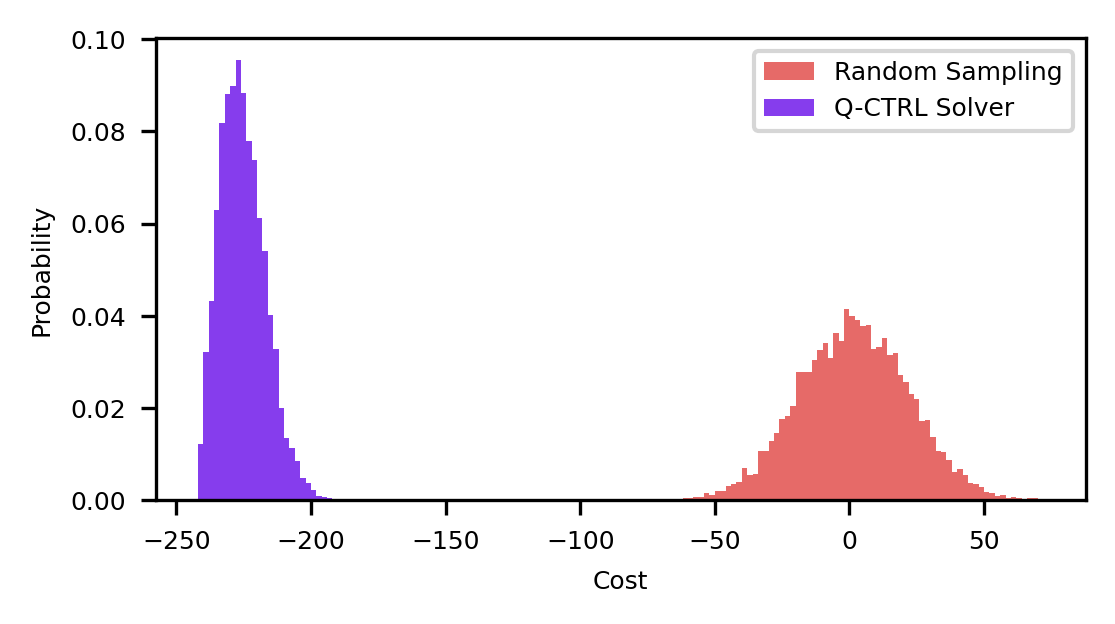

In [59]:
# Convert spin_glass_poly into a NumPy-compatible function
poly_as_numpy_function = lambdify(x, spin_glass_poly.as_expr(), "numpy")

# Function to compute the cost of a given bitstring using spin_glass_poly
def bitstring_cost(bitstring: str) -> float:
    # Convert bitstring to a reversed list of integers (0s and 1s)
    return float(poly_as_numpy_function(*[int(b) for b in str(bitstring[::-1])]))

# Calculate the cost of each bitstring in the distribution
costs = [bitstring_cost(k) for k, _ in distribution.items()]

# Extract probabilities from the bitstring distribution
probs = np.array([v for _, v in distribution.items()])
probs = probs / sum(probs)  # Normalize to get probabilities

plot_cost_histogram(costs, probs, distribution, qubit_count, bitstring_cost)

Since the goal of this optimization algorithm is to find the minimum ground state of the Ising model, lower values indicate better solutions. Therefore, it's visually apparent that the solutions generated by the Fire Opal Optimization Solver far outperform random selection.
